In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as skl
import numpy as np

#NOTE: If CUDA error comes while training, try restarting the kernel

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [215]:
# Hyper-parameteres
input_size = 2
hidden_sizes = np.array([5, 5])
num_classes = 3
num_epochs = 100
batch_size = 10
learning_rate = 0.001

In [216]:
# Read the data
import torch.utils


df = pd.read_csv("./Data/Classification/NLS_Group03.txt", header=None, names=["x", "y"], sep=' ')
index = df.reset_index(inplace = True)
df.columns = ['x', 'y', 'non']
df.drop('non', axis = 1, inplace = True)

# Assign class labels
df['class'] = 0
df.loc[:300, 'class'] = 0
df.loc[300:800, 'class'] = 1
df.loc[800:, 'class'] = 2

df_cls1 = df.iloc[:300]
df_cls2 = df.iloc[300:800]
df_cls3 = df.iloc[800:]

# Tweaking data for checking how good is model
condition = df['x'] <= -1.8
df.loc[condition, "class"] = 1

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# Train-test split
df_train, df_test = skl.train_test_split(df, test_size=0.3, train_size=0.7)

# Convert to tensors
df_train = torch.tensor(np.array(df_train), dtype=torch.float32)
df_test = torch.tensor(np.array(df_test), dtype=torch.float32)


In [217]:
train_loader = torch.utils.data.DataLoader(dataset=df_train,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=df_test,batch_size=batch_size,shuffle=True)

In [218]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        layers = []
        
        # Adding the first hidden layer and its activation
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Adding the subsequent hidden layers and their activations
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        
        # Adding the output layer (without activation)
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        # Combining all layers into a sequential container
        self.all_layers = nn.Sequential(*layers)
        
    def forward_propagation(self, x):
        return self.all_layers(x)


In [219]:

model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)


# Train model
total_steps = len(train_loader)

for epoch in range(num_epochs):
    # each iteration will give a batch of points 
    for i,data in enumerate(train_loader): 
        points = data[:, 0:2].clone().detach().float().to(device)
        labels = data[:,2].clone().detach().long().to(device)
        
        # forward prop
        outputs = model.forward_propagation(points)
        loss = loss_fn(outputs, labels)

        # backward prop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1) % 24 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

Epoch [1/100], Step [24/126], Loss: 1.1360
Epoch [1/100], Step [48/126], Loss: 1.0739
Epoch [1/100], Step [72/126], Loss: 1.0213
Epoch [1/100], Step [96/126], Loss: 0.8694
Epoch [1/100], Step [120/126], Loss: 1.0664
Epoch [2/100], Step [24/126], Loss: 0.9842
Epoch [2/100], Step [48/126], Loss: 1.0177
Epoch [2/100], Step [72/126], Loss: 0.9359
Epoch [2/100], Step [96/126], Loss: 0.8578
Epoch [2/100], Step [120/126], Loss: 0.8904
Epoch [3/100], Step [24/126], Loss: 0.9056
Epoch [3/100], Step [48/126], Loss: 0.8208
Epoch [3/100], Step [72/126], Loss: 0.8512
Epoch [3/100], Step [96/126], Loss: 0.8986
Epoch [3/100], Step [120/126], Loss: 0.8887
Epoch [4/100], Step [24/126], Loss: 1.0409
Epoch [4/100], Step [48/126], Loss: 0.8133
Epoch [4/100], Step [72/126], Loss: 0.9242
Epoch [4/100], Step [96/126], Loss: 0.9112
Epoch [4/100], Step [120/126], Loss: 0.9901
Epoch [5/100], Step [24/126], Loss: 0.7510
Epoch [5/100], Step [48/126], Loss: 0.8484
Epoch [5/100], Step [72/126], Loss: 0.6568
Epoch [

In [220]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Evaluate the model and collect predictions
points_list = []
true_labels_list = []
pred_labels_list = []

with torch.no_grad():
    good_pred = 0
    total_samples = len(test_loader.dataset)
    
    for i, data in enumerate(test_loader): 
        points = data[:, 0:2].clone().detach().float().to(device)
        labels = data[:, 2].clone().detach().long().to(device)

        outputs = model.forward_propagation(points)
        _, predictions = torch.max(outputs, 1) # max gives (output value, index)

        good_pred += (predictions == labels).sum().item()

        # Collect data for plotting
        points_list.append(points.cpu())
        true_labels_list.append(labels.cpu())
        pred_labels_list.append(predictions.cpu())

    accuracy = good_pred / total_samples
    print(f'Accuracy of the network on the {total_samples} test images: {100 * accuracy:.2f} %')



    


Accuracy of the network on the 540 test images: 98.52 %


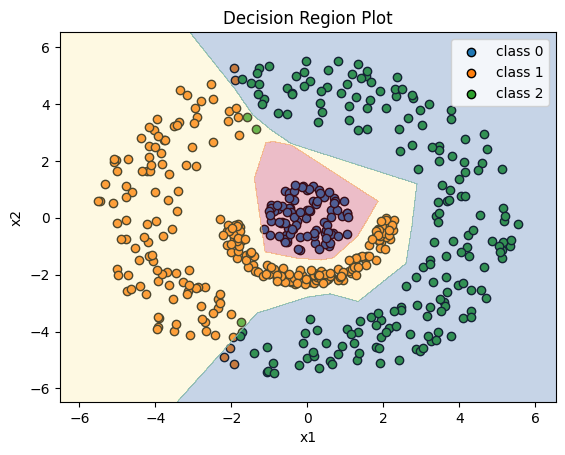

In [221]:
def decision_boundary(df_test):
    # Separate the test data into individual classes based on their true labels
    df_cls1 = df_test[df_test[:, 2] == 0]
    df_cls2 = df_test[df_test[:, 2] == 1]
    df_cls3 = df_test[df_test[:, 2] == 2]

    fig, axes = plt.subplots()
    axes.scatter(df_cls1[:, 0], df_cls1[:, 1], label='class 0', edgecolors='k')
    axes.scatter(df_cls2[:, 0], df_cls2[:, 1], label='class 1', edgecolors='k')
    axes.scatter(df_cls3[:, 0], df_cls3[:, 1], label='class 2', edgecolors='k')

    x_min, x_max = df_test[:, 0].min() - 1, df_test[:, 0].max() + 1
    y_min, y_max = df_test[:, 1].min() - 1, df_test[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Prepare the grid points for batch prediction
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    # Make predictions on the mesh grid using the trained perceptron model
    with torch.no_grad():
        outputs = model.forward_propagation(grid_points)
        _, grid_predictions = torch.max(outputs, 1)

    # Reshape the predictions into a 2D array
    Z = grid_predictions.cpu().numpy().reshape(xx.shape)

    # Plot the decision regions
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Spectral)
    plt.title('Decision Region Plot')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()


# Example usage
decision_boundary(df_test)
